### Simple Analysis on Graduate Admissions dataset
source: https://www.kaggle.com/mohansacharya/graduate-admissions

In [1]:
import pyspark
from os import listdir
from os.path import isfile, join
import boto3
import pandas as pd
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType

In [2]:
# initialize spark environment
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext.getOrCreate(conf=conf) # gets existing context otherwise creates new
sqlc = pyspark.sql.SQLContext(sc)

In [3]:
# read data from s3
role = get_execution_role()
bucket='odl-spark19spds6003-001'
data_key = 'sv2fr/Admission_Predict_Ver1.1.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
pdf = pd.read_csv(data_location)
pdf

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65
5,6,330,115,5,4.5,3.0,9.34,1,0.90
6,7,321,109,3,3.0,4.0,8.20,1,0.75
7,8,308,101,2,3.0,4.0,7.90,0,0.68
8,9,302,102,1,2.0,1.5,8.00,0,0.50
9,10,323,108,3,3.5,3.0,8.60,0,0.45


In [4]:
# data cleaning
pdf.drop(['Serial No.'], axis=1, inplace=True)
pdf.drop_duplicates(inplace=True)
pdf.dropna(inplace=True)
pdf.columns = ['GRE', 'TOEFL', 'Uni_Rank', 'SOP', 'LOR', 'CGPA', 'Research', 'Chance_of_Admit']
pdf

,GRE,TOEFL,Uni_Rank,SOP,LOR,CGPA,Research,Chance_of_Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65
5,330,115,5,4.5,3.0,9.34,1,0.90
6,321,109,3,3.0,4.0,8.20,1,0.75
7,308,101,2,3.0,4.0,7.90,0,0.68
8,302,102,1,2.0,1.5,8.00,0,0.50
9,323,108,3,3.5,3.0,8.60,0,0.45


In [5]:
# create dataframe
df = sqlc.createDataFrame(pdf)
df

DataFrame[GRE: bigint, TOEFL: bigint, Uni_Rank: bigint, SOP: double, LOR: double, CGPA: double, Research: bigint, Chance_of_Admit: double]

In [8]:
# convert to parquet (for efficient processing) and store in s3
parquetPath = '/home/ec2-user/SageMaker/tmp-pqt-sv2fr'
df.write.parquet(parquetPath)
files = [f for f in listdir(parquetPath) if isfile(join(parquetPath, f))]
s3 = boto3.resource('s3')
for f in files:
#     print('copying {} to {}'.format(parquetPath+'/'+f,"sample_data/"+f))
    s3.Bucket(bucket).upload_file(parquetPath +'/'+ f, "sv2fr/pqt/"+ f)

In [9]:
# write to spark dataframe from parquet
df = sqlc.read.parquet(parquetPath)
df

DataFrame[GRE: bigint, TOEFL: bigint, Uni_Rank: bigint, SOP: double, LOR: double, CGPA: double, Research: bigint, Chance_of_Admit: double]

In [11]:
# create training and validation sets
seed = 1
(validationDF, trainingDF) = df.randomSplit((0.20, 0.80), seed=seed)
print ('training set N = {}, validation set N = {}'.format(trainingDF.count(),validationDF.count()))

training set N = 382, validation set N = 118


In [13]:
print(df.columns[:7])

['GRE', 'TOEFL', 'Uni_Rank', 'SOP', 'LOR', 'CGPA', 'Research']


In [15]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# vectorize the data frame features
assembler = VectorAssembler(
    inputCols=df.columns[:7],
    outputCol="features")
trainingVDF = assembler.transform(trainingDF)
validationVDF = assembler.transform(validationDF)

# view the vectorized data frames
print("Assembled data frame columns to vector column 'features'")
trainingVDF.select("features").show(truncate=False)
validationVDF.select("features").show(truncate=False)

Assembled data frame columns to vector column 'features'
+----------------------------------+
|features                          |
+----------------------------------+
|[290.0,104.0,4.0,2.0,2.5,7.46,0.0]|
|[294.0,93.0,1.0,1.5,2.0,7.36,0.0] |
|[294.0,95.0,1.0,1.5,1.5,7.64,0.0] |
|[295.0,93.0,1.0,2.0,2.0,7.2,0.0]  |
|[295.0,99.0,1.0,2.0,1.5,7.57,0.0] |
|[295.0,101.0,2.0,2.5,2.0,7.86,0.0]|
|[296.0,95.0,2.0,3.0,2.0,7.54,1.0] |
|[296.0,97.0,2.0,1.5,2.0,7.8,0.0]  |
|[296.0,99.0,2.0,2.5,2.5,8.03,0.0] |
|[296.0,99.0,2.0,3.0,3.5,7.28,0.0] |
|[297.0,96.0,2.0,2.5,2.0,7.43,0.0] |
|[297.0,98.0,2.0,2.5,3.0,7.67,0.0] |
|[297.0,99.0,4.0,3.0,3.5,7.81,0.0] |
|[297.0,100.0,1.0,1.5,2.0,7.9,0.0] |
|[297.0,101.0,3.0,2.0,4.0,7.67,1.0]|
|[298.0,98.0,2.0,4.0,3.0,8.03,0.0] |
|[298.0,99.0,2.0,4.0,2.0,7.6,0.0]  |
|[298.0,101.0,2.0,1.5,2.0,7.86,0.0]|
|[298.0,101.0,4.0,2.5,4.5,7.69,1.0]|
|[299.0,94.0,1.0,1.0,1.0,7.34,0.0] |
+----------------------------------+
only showing top 20 rows

+----------------------------

In [20]:
# view the dataframes : new column of feature vector has been added
print(trainingVDF.show)
print(trainingVDF.show)

<bound method DataFrame.show of DataFrame[GRE: bigint, TOEFL: bigint, Uni_Rank: bigint, SOP: double, LOR: double, CGPA: double, Research: bigint, Chance_of_Admit: double, features: vector]>
<bound method DataFrame.show of DataFrame[GRE: bigint, TOEFL: bigint, Uni_Rank: bigint, SOP: double, LOR: double, CGPA: double, Research: bigint, Chance_of_Admit: double, features: vector]>


In [21]:
# define label columns 
trainingVDF = trainingVDF.withColumnRenamed("Chance_of_Admit", "label")
validationVDF = validationVDF.withColumnRenamed("Chance_of_Admit", "label")

In [22]:
# train the model
from pyspark.ml.regression import LinearRegression, LinearRegressionModel

lr = LinearRegression()
lrModel = lr.fit(trainingVDF)

In [24]:
# performance on validation set
from pyspark.ml.evaluation import RegressionEvaluator

predictionsAndLabelsDF = lrModel.transform(validationVDF)
eval = RegressionEvaluator()
print(eval.setMetricName("rmse").evaluate(predictionsAndLabelsDF))
print(eval.setMetricName("r2").evaluate(predictionsAndLabelsDF))

0.06826302980488663
0.7893919278782331


In [43]:
print(range(result_pdf.shape[0]))

range(0, 118)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


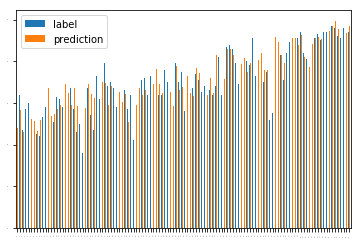

In [50]:
# visualizing : a comparision of original and predicted labels

import matplotlib.pyplot as plt

result_pdf = predictionsAndLabelsDF.toPandas()
result_pdf.plot(y = ["label", "prediction"], kind="bar", xticks=result_pdf.index, fontsize=0)
